In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from irt import IRTModel
from sklearn import svm
from sklearn.linear_model import SGDRegressor, LinearRegression, BayesianRidge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
# from beta_irt.visualization.plots import newline
# from beta_irt.visualization.plots import plot_parameters
from irt import beta_irt
from sklearn.decomposition import PCA
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import glob
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from beta_irt.visualization.plots import plot_parameters
from scipy.interpolate import spline

from scipy.interpolate import spline
from scipy.interpolate import make_interp_spline, BSpline

In [3]:
name = 'polynomial'

In [4]:
names = []
path = './Results_IRT/'+name+'_TARGET/'
foldernames = glob.glob(path+'*/')
keys = list(map(lambda x: int(x[:-1].split('_')[-1]), foldernames))
keys = sorted(range(len(keys)), key=lambda k: keys[k])
foldernames = list(map(lambda k: foldernames[k], keys))
names = list(map(lambda x: x.split('/')[-2], foldernames))
max_std = int(names[-1].split('_')[-1])
cmap1 = sns.cubehelix_palette(rot=-.5,light=1.5,dark=-.5,as_cmap=True)
fsz = 15
mdls = ['LR', 'Bayes', ' SVR(Lin)', ' SVR(Rbf)', 'KNR', 'DT', 'RF', 'AdaB', 'MLP100', 'MLP50-50', 'Avg', 'Opt', 'Wrs']

## Data set

In [ ]:
df = pd.read_csv('./data/SELECTED/polynomial.csv')
X = df.iloc[:, 0].values.reshape(-1,1)
y = df.iloc[:, 1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
inst = ['a','b','c','d']

plt.figure(figsize=(9, 6))

plt.scatter(X_train, y_train, label = 'Train',cmap = cmap1, edgecolor='k')
plt.scatter(X_test, y_test, label = 'Test', c='red',cmap = cmap1, edgecolor='k')
for i, pt in enumerate(np.sort(chosen_i)):
    plt.plot([X_test[pt],X_test[pt]], [y_test[pt], y_test[pt] + 1.5*pt], c='black')
    plt.text(x = X_test[pt], y = y_test[pt]+ 1.5*pt, s='Inst. {}' .format(inst[i]), fontsize = fsz)
plt.ylabel('y', fontsize= fsz)
plt.xlabel('X', fontsize= fsz)
plt.legend(fontsize = fsz)
plt.savefig('./Results_IRT/polynomial_PAPER/poly_dataset.png', bbox_inches = 'tight',
    pad_inches = 0)

In [6]:
foldernames

['./Results_IRT/polynomial_TARGET/noise_0/',
 './Results_IRT/polynomial_TARGET/noise_1/',
 './Results_IRT/polynomial_TARGET/noise_2/',
 './Results_IRT/polynomial_TARGET/noise_3/',
 './Results_IRT/polynomial_TARGET/noise_4/',
 './Results_IRT/polynomial_TARGET/noise_5/',
 './Results_IRT/polynomial_TARGET/noise_6/',
 './Results_IRT/polynomial_TARGET/noise_7/',
 './Results_IRT/polynomial_TARGET/noise_8/',
 './Results_IRT/polynomial_TARGET/noise_9/',
 './Results_IRT/polynomial_TARGET/noise_10/',
 './Results_IRT/polynomial_TARGET/noise_11/',
 './Results_IRT/polynomial_TARGET/noise_12/',
 './Results_IRT/polynomial_TARGET/noise_13/',
 './Results_IRT/polynomial_TARGET/noise_14/',
 './Results_IRT/polynomial_TARGET/noise_15/',
 './Results_IRT/polynomial_TARGET/noise_16/',
 './Results_IRT/polynomial_TARGET/noise_17/',
 './Results_IRT/polynomial_TARGET/noise_18/',
 './Results_IRT/polynomial_TARGET/noise_19/',
 './Results_IRT/polynomial_TARGET/noise_20/']

In [7]:
all_files = []
for i, df in enumerate(foldernames):
    path = df
    filenames = glob.glob(path + "/*.csv")
    
    filenames.sort()

    dfs = []
    for filename in filenames:
        dfs.append(pd.read_csv(filename))
        
    all_files.append(dfs)

In [8]:
filenames

['./Results_IRT/polynomial_TARGET/noise_20/errors_polynomial_s60_f20_sd42.csv',
 './Results_IRT/polynomial_TARGET/noise_20/irt_ability_vi_polynomial_s60_f20_sd42.csv',
 './Results_IRT/polynomial_TARGET/noise_20/irt_data_polynomial_s60_f20_sd42.csv',
 './Results_IRT/polynomial_TARGET/noise_20/irt_parameters_vi_polynomial_s60_f20_sd42.csv',
 './Results_IRT/polynomial_TARGET/noise_20/noise_polynomial_s60_f20_sd42.csv',
 './Results_IRT/polynomial_TARGET/noise_20/test_polynomial_s60_f20_sd42.csv']

In [9]:
all_files[0][-1].shape

(60, 2)

In [10]:
abilities = np.zeros((len(mdls), len(foldernames)))
noises = np.zeros((len(foldernames), len(all_files[0][-1])))
errors = np.zeros((len(foldernames), len(all_files[0][-1]), len(mdls) - 3))
responses = np.zeros((len(foldernames), len(all_files[0][-1]), len(mdls)))
params = np.zeros((len(foldernames), len(all_files[0][-1]), 2))
test = np.zeros((len(foldernames), len(all_files[0][-1]), 2))

In [11]:
for i, data in enumerate(all_files):
    abilities[:, i] = data[1].iloc[:, -1].values
    errors[i] = data[0].values
    responses[i] = data[2].values
    params[i] = data[3].values
    noises[i] = data[-2].values.reshape(1,-1)[0]
    test[i] = data[-1].values

# Noise x MAE

In [12]:
mae = np.zeros((len(all_files), 10))
norm_errors = np.zeros((len(all_files), 13))
for i in range(21):
    mae[i] = np.absolute(errors[i]).mean(axis=0)
    norm_errors[i] = ((1-responses[i])/responses[i]).mean(axis=0)

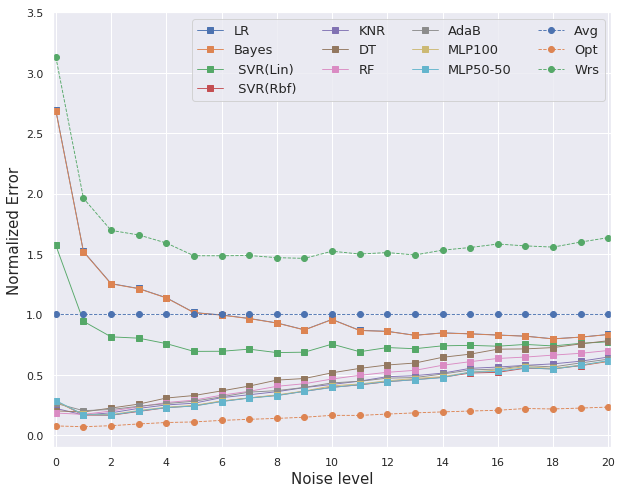

In [14]:
plt.figure(figsize=(10, 8))
for j, model in enumerate(mdls):
    if j < 10:
        plt.plot(list(range(21)), norm_errors[:, j], linewidth=0.9, label=model, marker='s',)
    else:
        plt.plot(list(range(21)), norm_errors[:, j], linewidth=0.9, label=model, marker='o', linestyle='--')
plt.xticks(range(0, 21, 2))

plt.xlim([-.1,20.1])
plt.ylim([-0.1, 3.5])

plt.ylabel('Normalized Error', fontsize = fsz)
plt.xlabel('Noise level', fontsize = fsz)
plt.legend(loc = 'best', ncol = 4, fontsize = fsz-2)
plt.savefig('./Results_IRT/' + name + '_TARGET/mae_noise.png', bbox_inches = 'tight', pad_inches = 0)

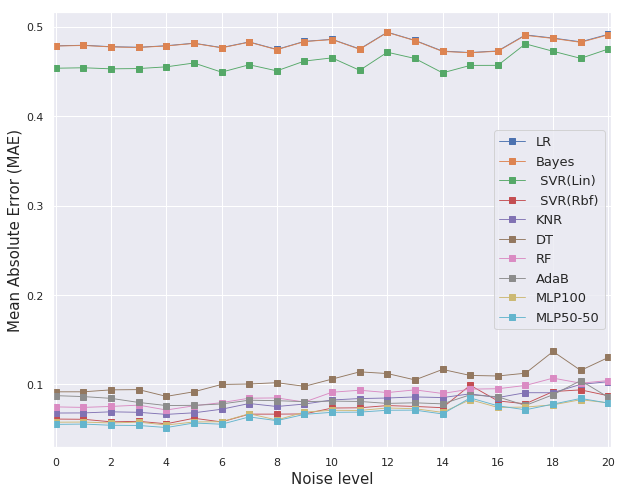

In [15]:
plt.figure(figsize=(10, 8))
for j, model in enumerate(mdls[:10]):
    plt.plot(list(range(21)), mae[:, j], linewidth=0.9, label=model, marker='s',)
plt.xticks(range(0, 21, 2))

plt.xlim([-.1,20.1])

plt.ylabel('Mean Absolute Error (MAE)', fontsize = fsz)
plt.xlabel('Noise level', fontsize = fsz)
plt.legend(fontsize = fsz-2)
plt.savefig('./Results_IRT/' + name + '_TARGET/mae_noise.png', bbox_inches = 'tight', pad_inches = 0)

# Noise x Ability

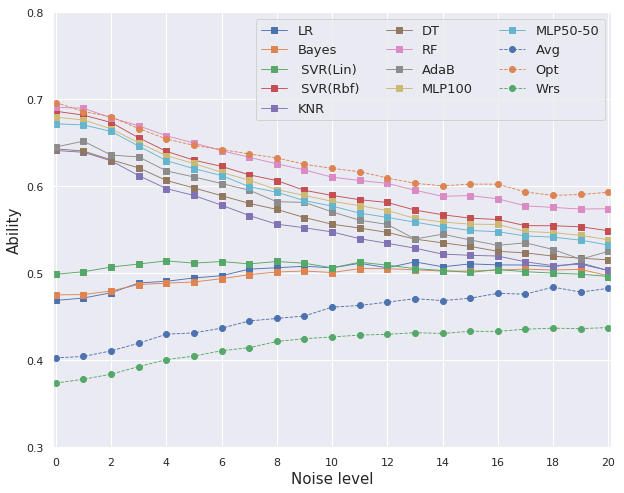

In [16]:
plt.figure(figsize=(10, 8))
for j, model in enumerate(mdls):
    if j>9:
        plt.plot(list(range(21)), abilities[j, :], linewidth=0.9, label=model, marker='o', linestyle = '--')
    else:
        plt.plot(list(range(21)), abilities[j, :], linewidth=0.9, label=model, marker='s')
plt.xticks(range(0, 21, 2))
plt.xlim([-.1,20.1])
plt.ylim([0.3,0.8])

plt.ylabel('Ability', fontsize=fsz)
plt.xlabel('Noise level', fontsize = fsz)
plt.legend(loc='best', ncol=3, fontsize=fsz-2)
plt.savefig('./Results_IRT/' + name + '_TARGET/noise_ability.png', bbox_inches = 'tight', pad_inches = 0)

# Histograms Responses

In [17]:
plts = ['Original', '50% Noise', '100% Noise']
plot = ['Difficulty', 'Discrimination']
noises_i = [0, 10, 20]
chosen_i = [55, 0, 15, 37]

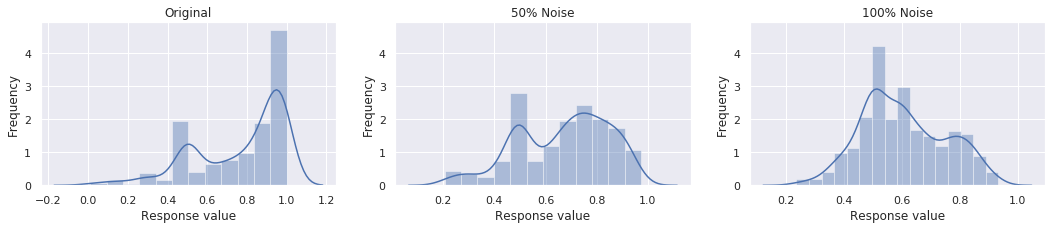

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(18,3))
scale = 0
for i, noise_i in enumerate(noises_i):
    values = all_files[noise_i][2].values.reshape(-1,1)
    sns.distplot(values, ax= axes[i])
    current_scale = axes[i].get_ylim()[1] - axes[i].get_ylim()[0]
    if current_scale > scale:
        scale = current_scale
        y_lim = axes[i].get_ylim()
    axes[i].set_title(plts[i])
    axes[i].set_xlabel('Response value')
    axes[i].set_ylabel('Frequency')
for ax in axes:
    ax.set_ylim(y_lim)
fig.savefig('./Results_IRT/'+name+'_TARGET/hists.png')

# IRT Parameters

In [19]:
noises.shape

(21, 60)

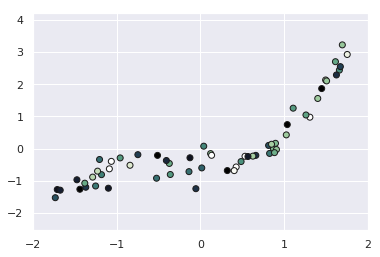

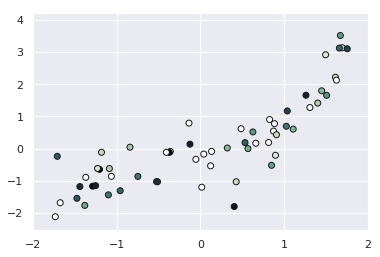

In [29]:
for i in noises_i[1:]:
    plt.scatter(test[i][:, 0], test[i][:, 1], c= noises[i], cmap=cmap1, edgecolors='k')
    plt.ylim([test[-1][:,1].min()*1.2, test[-1][:,1].max()*1.2])
    plt.xticks(range(-2,3))
    plt.savefig('./Results_IRT/polynomial_TARGET/y_noise_{}.png'.format(str(i)), bbox_inches = 'tight',
    pad_inches = 0)
    plt.show()

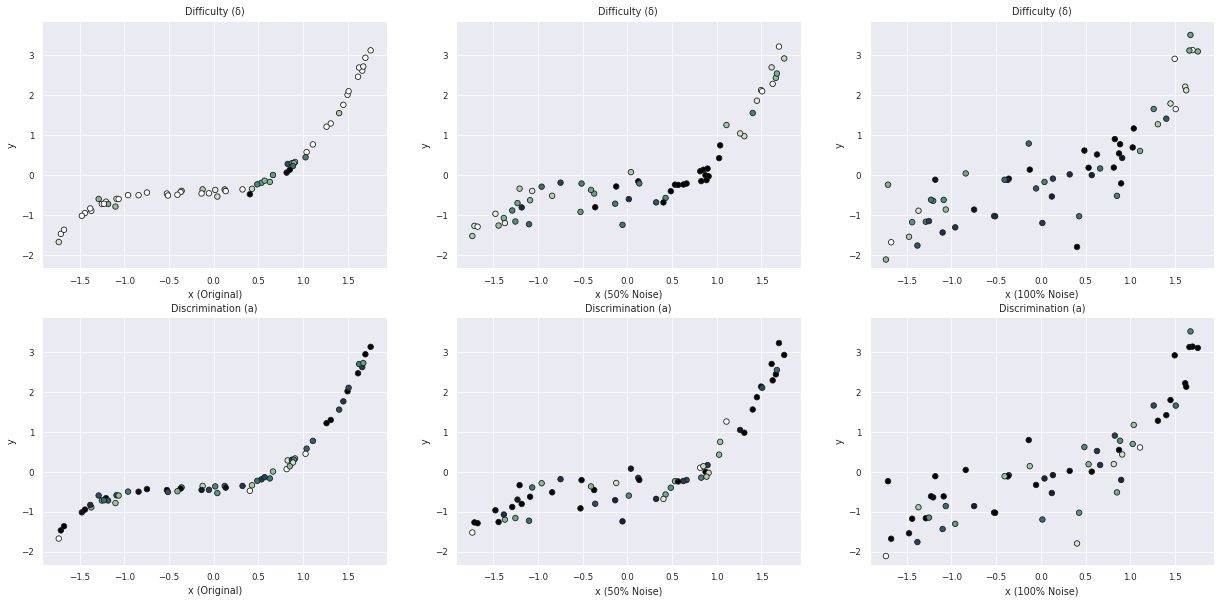

In [31]:
scale = 0
fig, axes = plt.subplots(2, 3, figsize=(21,10))

for i, title in enumerate(plot):
    for j,noise in enumerate(noises_i):        
        axes[i,j].set_ylim([1.1*test[-1][:, 1].min(), 1.1*test[-1][:, 1].max()])
#         axes[i,j].set_ylim([.85*test[-1][:, 1].min(), 1.15*test[-1][:, 1].max()])    
        
        c = params[noise][:, i]
        
        sns.set_context('paper')

        axes[i, j].scatter(test[noise][:, 0], test[noise][:, 1], c = c, cmap = cmap1, edgecolor='k',s=30)
        
        axes[i,j].set_xlabel('x (' + plts[j]+')')
        axes[i,j].set_ylabel('y')
        axes[i,j].set_title(title + (' (ẟ)' if i == 0 else ' (a)'))
plt.savefig('./Results_IRT/' + name + '_TARGET/params_noise.png')

# Difficulty/ Discrimination

In [32]:
Xsort_i = np.argsort(test[0][:, 0].reshape(1,-1))
X_test = test[0][:, 0]
p_mean = params.mean(axis=0)
p_std = params.std(axis=0)

In [33]:
p_x = pd.Series(params[0][:, 0])
ma = p_x.rolling(window=3).mean()

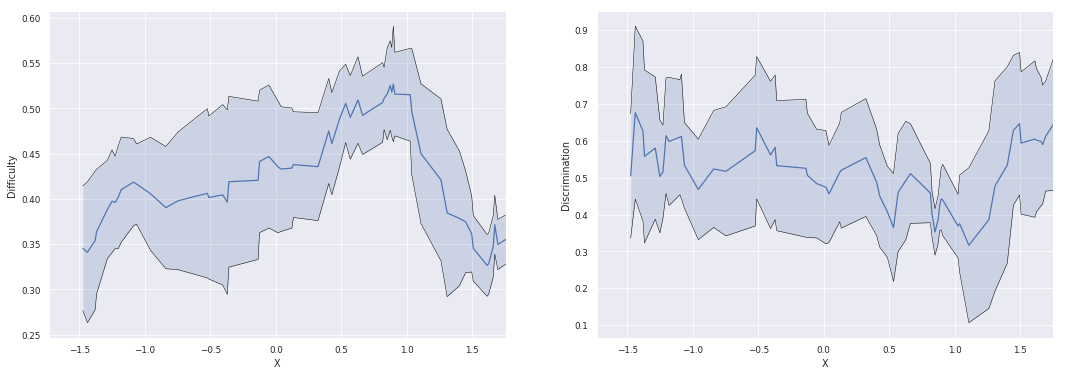

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
for i, param in enumerate(plot):
    x = X_test[Xsort_i].reshape(1,-1)[0]
    pmean = pd.Series(p_mean[Xsort_i, i][0])
    pstd = pd.Series(p_std[Xsort_i, i][0])
    
    axes[i].fill_between(x, y1 = (pmean - 2*pstd).rolling(window=4).mean(), y2 = (pmean + 2*pstd).rolling(window=4).mean(), alpha=0.2)
    axes[i].plot(x, pmean.rolling(window=4).mean())
    axes[i].plot(x, (pmean - 2*pstd).rolling(window=4).mean(), linewidth = 0.5, c='black')
    axes[i].plot(x, (pmean + 2*pstd).rolling(window=4).mean(), linewidth = 0.5, c='black')
    axes[i].set_xlabel('X')
    axes[i].set_xlim([x[0], x[-1]])
    axes[i].set_ylabel(param)
# plt.savefig('./Results_IRT/' + name + '/params_x.png')
plt.show()

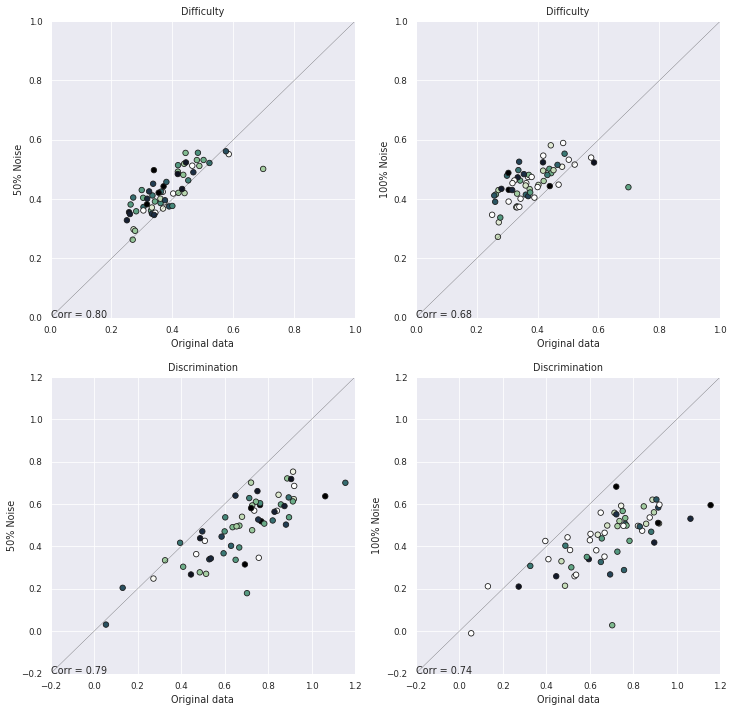

In [35]:
#Lower noise
scale = 0
fig, axes = plt.subplots(2, 2, figsize=(12,12))

for i, title in enumerate(plot):
    for j,noise in enumerate(noises_i[1:]):
        if i == 0:
            lim = np.array([0,1])
        else:
            lim = np.array([-0.2, 1.2])
        
        axes[i,j].set_xlim(lim)
        axes[i,j].set_ylim(lim)
        axes[i,j].plot([lim[0],lim[1]], [lim[0], lim[1]], linewidth=0.2, c='black')        
        
        sns.set_context('paper')

        axes[i,j].text(x = lim[0], y = lim[0], s='Corr = %.2f' %(spearmanr(a = params[0][:, i], b = params[noise][:, i])[0]))
        axes[i, j].scatter(params[0][:, i], params[noise][:, i], c = noises[noise], cmap = cmap1, edgecolor='k',s=30)

        axes[i,j].set_xlabel("Original data")
        axes[i,j].set_ylabel(plts[j+1])
        axes[i,j].set_title(title)
fig.savefig('./Results_IRT/'+name+'_TARGET/parameters.png')

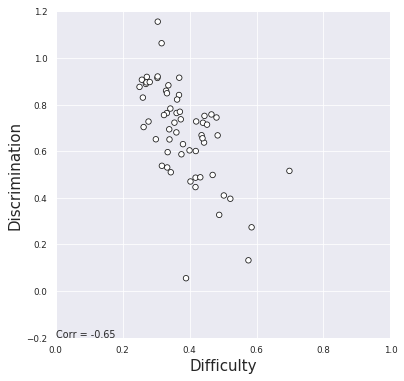

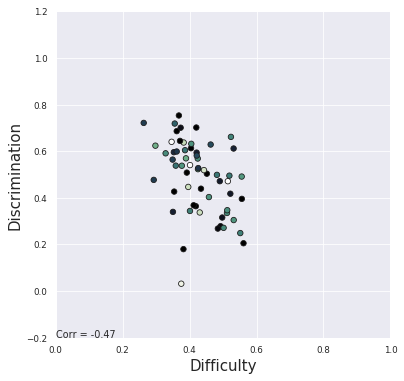

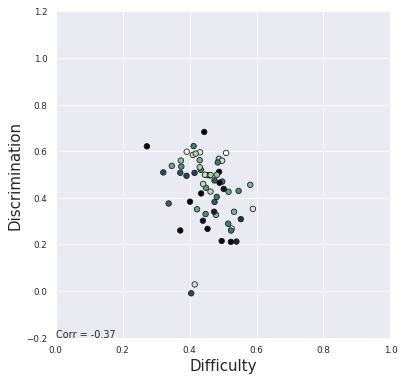

In [36]:
# fig, axes = plt.subplots(1, 3, figsize=(16,5))
for i, noise in enumerate(noises_i):
    plt.figure(figsize=(6, 6))
    c = np.absolute(noises[i])

    plt.scatter(params[noise][:,0], params[noise][:,1], c = c, cmap = cmap1, edgecolor='k',s=30)
    plt.text(x = 0, y = -.2, s='Corr = %.2f' %(spearmanr(a = params[noise][:,0], b= params[noise][:,1])[0]))

#     plt.title(plts[i])
    plt.xlim([0,1])
    plt.ylim([-0.2, 1.2])
    plt.xlabel('Difficulty', fontsize=fsz)
    plt.ylabel('Discrimination',fontsize=fsz)
    plt.savefig('./Results_IRT/'+name+'_TARGET/dif_disc_' + str(noise))

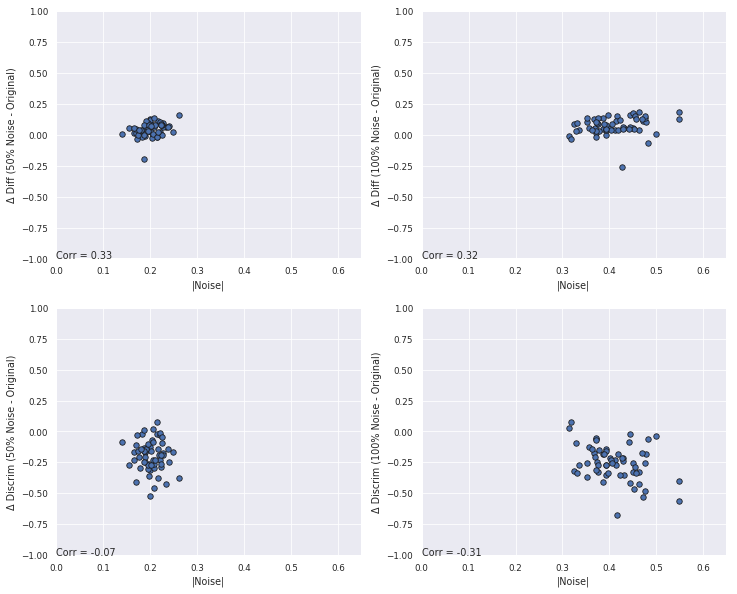

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))
for h, param in enumerate(['Diff', 'Discrim']):
    for i, noise in enumerate(noises_i[1:]):
        axes[h, i].scatter(noises[noise], (params[noise][:, h] - params[0][:, h]), edgecolor='k',s=30)
        axes[h, i].set_ylim([-1., 1.])
        axes[h, i].set_xlim([0, noises[-1].max() + 0.1])
        axes[h, i].text(x = 0, y = -1, s='Corr = %.2f' %(spearmanr(a = noises[noise], b = (params[noise][:, h] - params[0][:, h]))[0]))

        axes[h, i].set_xlabel('|Noise|')
        axes[h, i].set_ylabel('Δ '+param+' ('+plts[i+1]+' - Original)')
fig.savefig('./Results_IRT/'+name+'_TARGET/param_noise')

# Ability

In [38]:
abilities.shape

(13, 21)

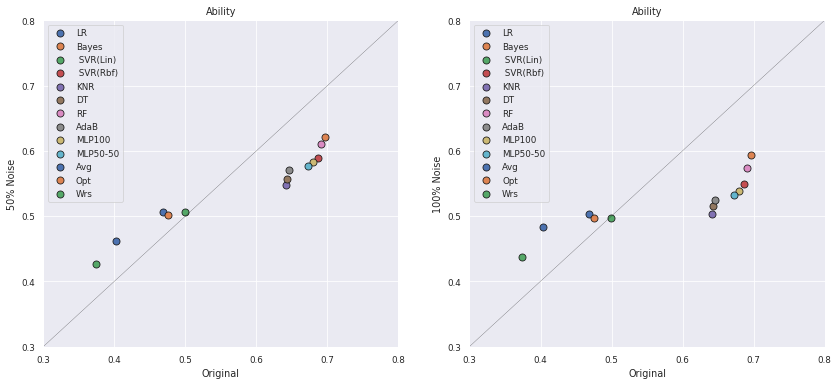

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))
lim = [0.3, 0.8]

for i, noise in enumerate(noises_i[1:]):
    for j, mdl in enumerate(mdls):
        axes[i].scatter(abilities[j, 0], abilities[j, noise], s = 50, label = mdl, edgecolor='k')
    axes[i].set_xlim(lim)
    axes[i].set_ylim(lim)
    axes[i].set_xlabel('Original')
    axes[i].set_ylabel(plts[i+1])
    axes[i].set_title('Ability')
    axes[i].plot(lim, lim, linewidth=0.2, c='black')
    axes[i].legend()
# fig.savefig('./Results_IRT/'+name+'/ability')

# Error

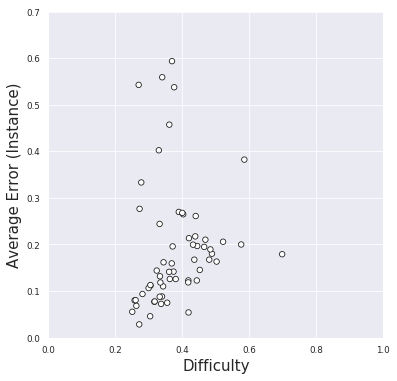

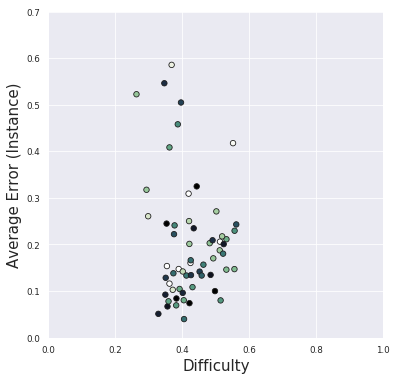

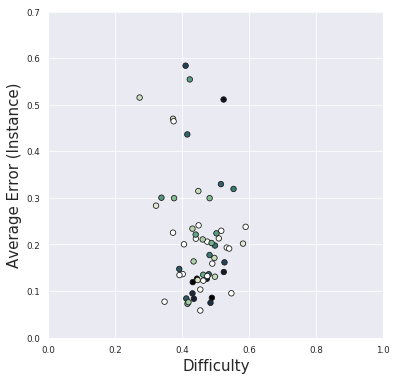

In [42]:
# fig, axes = plt.subplots(1, 3, figsize=(16,5))
for i, noise in enumerate(noises_i):
    plt.figure(figsize=(6, 6))
    c = np.absolute(noises[noise])
    mean_error = np.absolute(errors[noise]).mean(axis = 1)
    diff = params[noise][:, 0]
    plt.scatter(diff,mean_error, c= c, cmap = cmap1, edgecolor='k',s=30)
#     plt.text(x = 0, y = 0, s='Mean = %.2f Std = %.2f Corr = %.2f' %(mean_error.mean(), mean_error.std(), spearmanr(a = diff, b = mean_error)[0]), fontsize=10)
    plt.xlabel('Difficulty', fontsize=fsz)
    plt.ylabel('Average Error (Instance)', fontsize=fsz)
    plt.xlim([0,1])
    plt.ylim([0, 1.2*np.absolute(errors[-1]).mean(axis = 1).max()])
#     plt.title(plts[i])
    plt.savefig('./Results_IRT/'+name+'_TARGET/diff_error_' + str(noise))

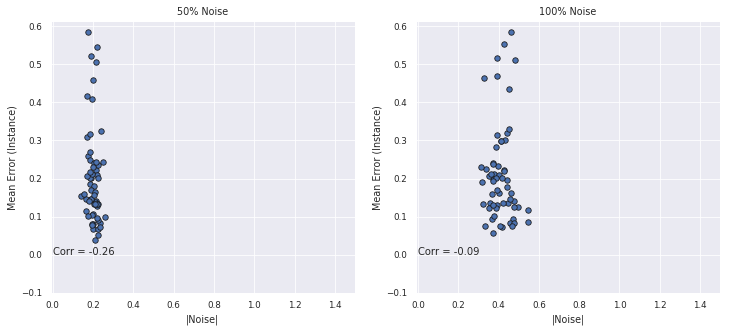

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
for i, noise in enumerate(noises_i[1:]):
    mean_error = np.absolute(errors[noise]).mean(axis = 1)
    axes[i].scatter(noises[noise], mean_error, edgecolor='k',s=30)
    axes[i].text(x = 0, y = 0, s='Corr = %.2f' %(spearmanr(a = noises[noise], b = mean_error)[0]), fontsize=10)
    axes[i].set_xlabel('|Noise|')
    axes[i].set_ylabel('Mean Error (Instance)')
    axes[i].set_xlim([-0.01, 1.5])
    axes[i].set_ylim([-0.1, 1.05*np.absolute(errors[-1]).mean(axis = 1).max()])
    axes[i].set_title(plts[i+1])
fig.savefig('./Results_IRT/'+name+'_TARGET/noise_error')

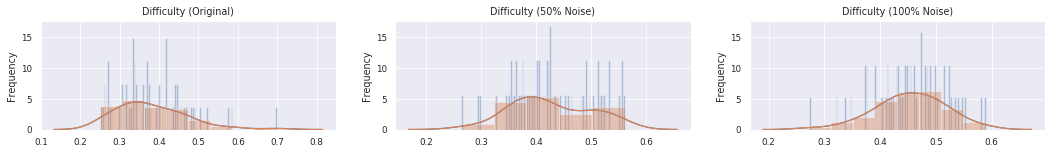

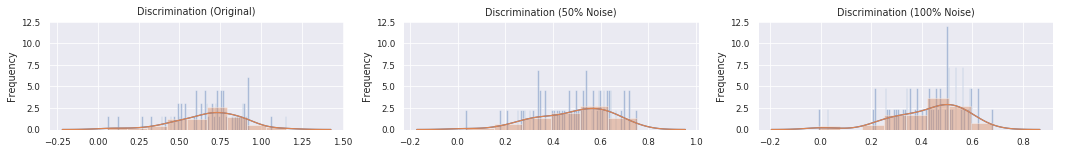

In [44]:
for h, param in enumerate(plot):
    sns.set_context('paper')
    scale = 0
    fig, axes = plt.subplots(1, 3, figsize=(18,2))
    for i, noise in enumerate(noises_i):
        values = params[noise][:, h]
        sns.distplot(values,bins=100,ax=axes[i])
        sns.distplot(values, ax= axes[i])
        current_scale = axes[i].get_ylim()[1] - axes[i].get_ylim()[0]
        if current_scale > scale:
            scale = current_scale
            y_lim = axes[i].get_ylim()
        axes[i].set_title(param + ' (' + plts[i] + ')')
        axes[i].set_ylabel('Frequency')
    for ax in axes:
        ax.set_ylim(y_lim)
    fig.subplots_adjust(hspace=0.3)
    fig.savefig('./Results_IRT/'+name+'_TARGET/hists_' + param + '.png')

In [45]:
ind = np.lexsort((params[0,:,0], params[0,:,1]))

In [ ]:
params[0, ind,:]

In [47]:
ind

array([ 0, 52, 10, 18, 22, 35, 29,  6, 28, 47, 34, 19, 55, 14, 57, 54, 44,
        1, 37, 51, 33, 43, 16, 40, 59, 12, 49,  3, 17, 45,  7, 56, 23, 31,
        2, 25, 42, 48, 36,  8, 13, 26, 30, 38, 50, 20, 58, 11, 46,  9,  4,
       41, 53, 32, 21, 27,  5, 39, 24, 15])

## Response

In [ ]:
# +Diff+Disc/ -Diff-Disc/ -Diff+Disc/ +Diff-Disc
chosen_i = [55, 0, 15, 37]
ab = np.linspace(0.0001, 0.9999, 200)
sub_noise = ['Noise free', '50% Noise', '100% Noise']

for j in (chosen_i):
    plt.figure(figsize=(6, 6))
    par = params[0, j, :]
    diff = par[0]
    disc = par[1]
    E = [beta_irt(x, diff, disc) for x in ab]
    middle = np.where(np.array(E)>0.499)[0][:2]
    p1 = [ab[middle[0]], E[middle[0]]]
    p2 = [ab[middle[1]], E[middle[1]]]
    newline(p1,p2)
    slope = (E[middle[1]] - E[middle[0]])/(ab[middle[1]] - ab[middle[0]])
    plt.text(p2[0], p2[1], 'slope = '+str(round(slope, 3)),fontsize=15)
    plt.plot(ab, E,)
    plt.plot([ab[middle[0]], ab[middle[0]]],[0, E[middle[0]]], '--r')
    plt.plot([0, ab[middle[0]]],[E[middle[0]], E[middle[0]]], '--r')
    plt.scatter(abilities[:, 0], responses[0, j, :], marker= 'x', c = 'red')
    plt.ylabel('Response', fontsize=fsz)
    plt.xlabel('Ability', fontsize=fsz)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
#     plt.title('Instance ' + str(j))
#         plt.legend()
    plt.savefig('./Results_IRT/'+name+'_TARGET/instance_' + str(j) + '.png')

## Relative Error

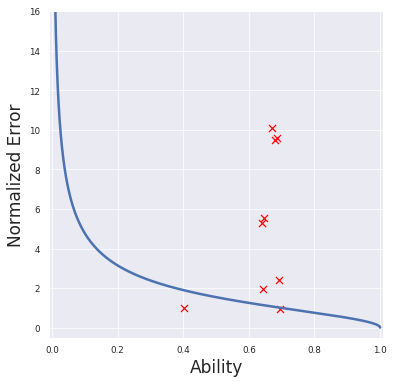

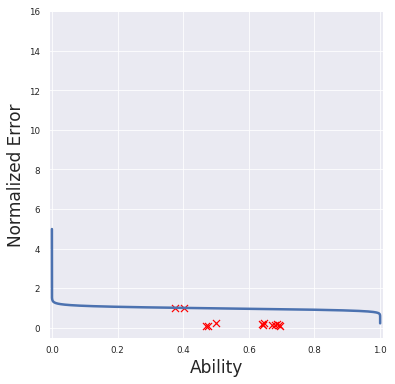

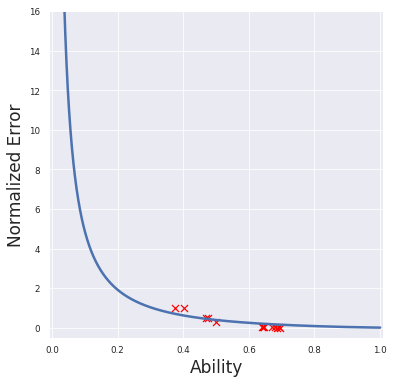

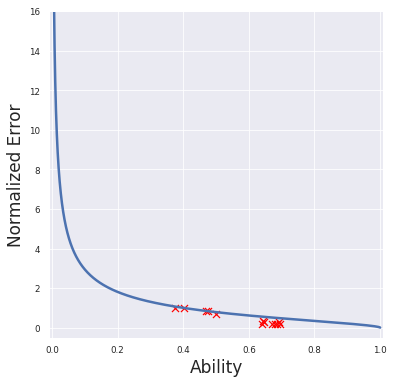

In [49]:
# +Diff+Disc/ -Diff-Disc/ -Diff+Disc/ +Diff-Disc
chosen_i = [55, 0, 15, 37]
ab = np.linspace(0.0000000000001, 0.999999999999, 5000000)
sub_noise = ['Noise free', '50% Noise', '100% Noise']

for j in (chosen_i):
    plt.figure(figsize=(6, 6))
    par = params[0, j, :]
    diff = par[0]
    disc = par[1]
    E = [beta_irt(x, diff, disc) for x in ab]
    E = list(map(lambda res: (1-res)/res, E))
#     middle = np.where(np.array(E)>0.499)[0][:2]
#     p1 = [ab[middle[0]], E[middle[0]]]
#     p2 = [ab[middle[1]], E[middle[1]]]
#     newline(p1,p2)
#     slope = (E[middle[1]] - E[middle[0]])/(ab[middle[1]] - ab[middle[0]])
#     plt.text(p2[0], p2[1], 'slope = '+str(round(slope, 3)),fontsize=15)
    plt.plot(ab, E, linewidth=2.5)
    response = responses[0][j, :]
    plt.scatter(abilities[:, 0], (1-response)/response, marker='x', c='red', s=50)
#     plt.plot([ab[middle[0]], ab[middle[0]]],[0, E[middle[0]]], '--r')
#     plt.plot([0, ab[middle[0]]],[E[middle[0]], E[middle[0]]], '--r')
#     plt.scatter(abilities[:, 0], responses[0, j, :], marker= 'x', c = 'red')
    plt.ylabel('Normalized Error', fontsize=fsz+2)
    plt.xlabel('Ability', fontsize=fsz+2)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.5, 16])
#     plt.title('Instance ' + str(j))
#         plt.legend()
    plt.savefig('./Results_IRT/'+name+'_TARGET/err_instance_' + str(j) + '.png', bbox_inches = 'tight',
    pad_inches = 0)

In [ ]:
abilities[:, 0].shape

In [ ]:
for i, noise in enumerate(noises_i):
    metrics = pd.DataFrame()
    metrics['Avg. Response'] = responses[noise][:, :-3].mean(axis = 0)
    metrics['Ability'] = abilities[:-3][noise]
    metrics['MAE'] = np.absolute(errors[i]).mean(axis = 0)
    metrics['MSE'] = (errors[]**2).mean(axis = 0)
    print(noise,'\n',metrics.corr(method = 'spearman'),'\n\n')